<a href="https://colab.research.google.com/github/Bharath2/cube/blob/master/sac_vaeFJM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install MuJoCo

In [ ]:
mjkey = """

MuJoCo Pro Individual license activation key, number 7705, type 6.

Issued to Everyone.

Expires October 31, 2021.

Do not share this file with anyone other than the users covered
by your license agreement with Roboti LLC. This file activates
MuJoCo Pro on any computer running any supported OS.

Do not modify this file. Its entire content, including the
plain text section, is used by the activation manager.

de6c23a3223b31727c2e09220e61f9f28ec9a0a234fd7ef6299d8167e86db350
b21ad1e630a5f9bc14c5c09fb19dac66c0d07a8b2640bad5c4b0d88de1762beb
ce1479fb291276f3557337858fba42c57ff9a28546ef78caf0cb3e16aec3aab3
8b8954e8b568c41cfe922c5a467dd66941f82eca99b14117ae490187687ad8f2
d6ffad21e5d12f84e5726e3f6c3d4faf060c5a0b95aa5c1b0a276e5fab463dec
388681bb9211f97e9f63c279deb849bb3c06eef490a650c862b68d0c51686a89
1a8464553437bd6675b32e9657a3b567000677847b25df38cea3132d6838b063
53100e1f45c61da292ec15850f563d76135ae2e8b8bb6483f5e8a4c32e44b8b3


""".strip()

mujoco_dir = "$HOME/.mujoco"

# Fetch MuJoCo binaries from Roboti
!wget -q https://www.roboti.us/download/mujoco200_linux.zip -O mujoco.zip
!unzip -o -q mujoco.zip -d "$mujoco_dir"

# Copy over MuJoCo license
!echo "$mjkey" > "$mujoco_dir/mjkey.txt"

In [ ]:
# Install dm_control
!pip install dm_control
!pip install recordclass
!pip install stable-baselines3[extra]

In [ ]:
import base64
import imageio 
from IPython.display import HTML
from IPython.display import clear_output

def write_video(frames, fps, filename = 'a.mp4'):            
    with imageio.get_writer(filename, fps=fps) as video:
        for frame in frames: video.append_data(frame)

def display_video(filename = 'a.mp4'):
    """Save and display video."""
    video = open(filename, 'rb').read()
    b64_video = base64.b64encode(video)
    video_tag = ('<video  width="240" height="240" controls alt="test" '
               'src="data:video/mp4;base64,{0}">').format(b64_video.decode())
    return HTML(video_tag)

In [ ]:
# General
import os
import copy
from itertools import count

import time, gym
from gym import spaces
from tqdm import tqdm

import PIL.Image
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Configure dm_control to use the egl rendering backend
%env MUJOCO_GL=egl
#dm_control
from dm_control import mjcf
from dm_control import mujoco

env: MUJOCO_GL=egl


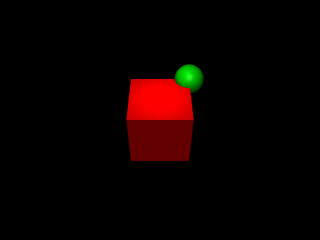

In [ ]:
#@title A static model {vertical-output: true}

static_model = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
    <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
  </worldbody>
</mujoco>
"""
physics = mujoco.Physics.from_xml_string(static_model)
pixels = physics.render()
PIL.Image.fromarray(pixels)

#FJM Model

In [ ]:
def FJM(payload_mass = 0.5):
    model = mjcf.RootElement()

    model.compiler.inertiafromgeom = True
    model.option.timestep = 0.001

    model.default.joint.damping = 0.1
    model.default.joint.type = 'hinge'
    model.default.joint.axis = '0 0 1'

    model.default.geom.type = 'box'
    model.default.geom.size = [1/32, 0.015, 0.015]
    model.default.geom.density = 555.55
    model.default.geom.contype = 0
    model.default.geom.conaffinity = 0


    base = model.worldbody.add('body', name = 'base')
    base.add('geom', type = 'cylinder', size = "0.03 0.025", rgba = "0.2 0.2 0.2 1", density = 0.01)

    link = base.add('body', pos = [1/32, 0, 0], name = 'body0')
    joint0 = link.add('joint', name = "joint0", pos = [-1/32, 0, 0], armature = 0.01,)
    link.add('geom', name = 'geom0', rgba = "0.9 0.3 0.2 1")

    for i in range(1, 16):
        link = link.add('body', pos = [1/16, 0, 0], name = 'body'+str(i))
        joint = link.add('joint', name = 'joint'+str(i), stiffness = 20, pos = [-1/32, 0, 0])
        rgba ='0.9 0.3 0.2 1' if not i%2 else "0.2 0.3 0.9 1"
        link.add('geom', name = 'geom'+str(i), rgba = rgba)
        
    ds = payload_mass/(np.pi*0.025**3*2)

    payload = link.add('body', pos = [1/32, 0, 0], name = 'payloadbody')
    payload.add('geom', name = 'payload', type = 'cylinder', size = "0.025 0.025", rgba = "0.4 0.4 0.4 1", density = ds)

    model.actuator.add('motor', joint = joint0, name = 'BaseMotor')
    
    return model

In [ ]:
def FJMModel(payload_mass = 0.5):
    arena = mjcf.RootElement()

    arena.worldbody.add('geom', type = 'plane', size = [3, 3, .1], rgba = '1 1 1 1')
    for x,y in zip((0, 0, 3.5, -3.5),(-3.5, 3.5, 0, 0)):
        arena.worldbody.add('light', pos = [x, y, 5])    
    arena.worldbody.add('camera', name = 'up', pos = [0, 0, 4], fovy = 30)
    obs = arena.worldbody.add('body', name = 'obs')
    
    model = FJM(payload_mass)

    spawn_site = arena.worldbody.add('site', pos = '0 0 0.01', name = 'FJMsite')
    spawn_site.attach(model)
    
    return arena

arena = FJMModel()
physics = mjcf.Physics.from_mjcf_model(arena)
img = physics.render(camera_id = 'up', height = 320, width = 320)

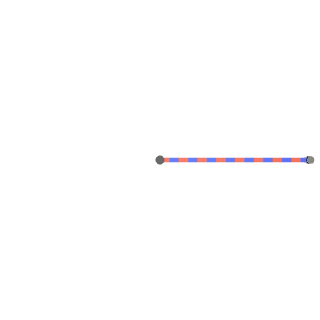

In [ ]:
PIL.Image.fromarray(img)

In [ ]:
duration = 2   # (Seconds)
framerate = 50  # (Hz)
video = []

physics.reset()
while physics.data.time < duration:
    physics.set_control([2])
    start = physics.data.time
    while physics.data.time - start < 0.02:
        physics.step()

    pixels = physics.render(camera_id = 'up', height = 320, width = 320)
    video.append(pixels.copy())

In [ ]:
write_video(video, framerate)
display_video()

In [ ]:
x, y, z = physics.data.xpos[-1]

In [ ]:
physics.get_state()

array([ 5.60888194e+00, -5.75320125e-02, -4.49117824e-02, -3.50437082e-02,
       -2.73365458e-02, -2.13177863e-02, -1.66134332e-02, -1.29292244e-02,
       -1.00344241e-02, -7.74837059e-03, -5.92957667e-03, -4.46704221e-03,
       -3.27342473e-03, -2.27974458e-03, -1.43135046e-03, -6.84921585e-04,
        4.94179970e+00,  3.97842781e-02,  3.83198175e-02,  3.61266579e-02,
        3.35402368e-02,  3.07676262e-02,  2.79281732e-02,  2.50831342e-02,
        2.22570351e-02,  1.94530112e-02,  1.66638664e-02,  1.38801534e-02,
        1.10962329e-02,  8.31500267e-03,  5.55177407e-03,  2.83760121e-03])

# **Import Torch**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions.normal import Normal
from torch.nn.utils import clip_grad_value_


# if gpu is to be used
if torch.cuda.is_available():
  device = torch.device("cuda")
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
  device = torch.device("cpu")
  torch.set_default_tensor_type(torch.FloatTensor)

#VAE

In [ ]:
from torchvision.models import resnet18

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc_hidden = 256
        self.embed_dim = 64

        enc = resnet18()
        enc.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        enc.fc = nn.Linear(enc.fc.in_features, self.fc_hidden)

        self.enc = enc
        self.fc_mu = nn.Linear(self.fc_hidden, self.embed_dim)      # output = CNN embedding latent variables
        self.fc_logvar = nn.Linear(self.fc_hidden, self.embed_dim)  # output = CNN embedding latent variables


    def forward(self, x):

        x = self.enc(x)
        x = x.view(x.size(0), -1)
        x = F.silu(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        return mu, logvar


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.embed_dim = 64
        self.fc_hidden = 256

        self.fc = nn.Sequential( 
            nn.Linear(self.embed_dim, self.fc_hidden),
            nn.SiLU(),
            nn.Linear(self.fc_hidden, 64 * 4 * 4),
            nn.SiLU(),
        )

        self.convTrans1 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size = (5, 5), stride=(3, 3), output_padding = 1),
            nn.BatchNorm2d(32, momentum=0.01),
            nn.ReLU(inplace = True),
        )
        self.convTrans2 = nn.Sequential(
            nn.ConvTranspose2d(32, 8, kernel_size = (5, 5), stride=(3, 3),),
            nn.BatchNorm2d(8, momentum=0.01),
            nn.ReLU(inplace = True),
        )
        self.convTrans3 = nn.Sequential(
            nn.ConvTranspose2d(8, 1, kernel_size = (3, 3), stride=(2, 2),),
            nn.BatchNorm2d(1, momentum=0.01),
            nn.Sigmoid()
        )

    def forward(self, x):

        x = self.fc(x).view(-1, 64, 4, 4)
        x = self.convTrans1(x)
        x = self.convTrans2(x)
        x = self.convTrans3(x)
        x = F.interpolate(x, size=(128, 128), mode='bilinear', align_corners=True)
        return x



class Vae(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):

        mu, logvar = self.encoder(x)
        std = logvar.mul(0.5).exp_()
        z = Normal(mu, std).rsample()
        recon_x = self.decoder(z)

        return recon_x, z, mu, logvar
    

    def loss(self, x):
        recon_x, z, mu, logvar = self.forward(x)
        MSE = F.mse_loss(recon_x, x, reduction='sum')
        # MSE = F.binary_cross_entropy(recon_x, x, reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return MSE + KLD

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving vae to vae (2)


In [ ]:
vae = Vae()

In [ ]:
state = torch.load('vae (2)', map_location = device)
vae.load_state_dict(state['vae'])

<All keys matched successfully>

#FJM Gym Env

In [ ]:
import gym

def ang_norm(x):
    return (((x + np.pi) % (2*np.pi)) - np.pi)

scale = np.r_[[np.pi],[0.5]*15, 15, [8]*15]

class FJMEnv(gym.Env):
    """Environment that follows gym interface"""
    metadata = {'render.modes': ['human']}

    def __init__(self, init_state = None, mass = 0.5, dt = 0.02):
        gym.Env.__init__(self)

        self.env = mjcf.Physics.from_mjcf_model(FJMModel(0.5))

        self.dt = dt
        self.ns = int(dt/0.001)
        self.maxsteps = 200
        self.state = None
        self.action = 0
        self.reset()

        self.action_space = gym.spaces.Box(low = -1, high = 1, shape = (1, ), dtype = np.float32)
        self.observation_space = gym.spaces.Box(low = -1, high = 1, shape = (4, 128, 128), dtype = np.float32)

    def step(self, action):
        self.action = action
        self.env.set_control(4*action)
        for _ in range(self.ns): self.env.step()
        reward, done = self._compute()
        self.states[:-1] = self.states[1:]
        self.states[-1] = self.get_state
 
        if done: reward = -50
        info = {'Terminal': 'Limit'} if done else {'Terminal': ''}
        if next(self.counter) >= self.maxsteps:
            done, info = True, {'Terminal': 'Timeout'}

        return np.hstack(self.states), reward, done, info


    def reset(self, init = None):

        with self.env.reset_context():
            if init is None:
                init = np.random.uniform(-1, 1, 4)
                init = init * [np.pi, 0.5, 0.5, 0.5]
            init = [init[0]] + [init[1]/15]*15 + [init[2]] + [0]*15
            self.env.set_state(np.array(init))
        self.counter = count(1)
        self.states = np.array([self.get_state]*4)
        return np.hstack(self.states)
    
    @property
    def get_state(self):
        state = self.env.get_state()
        x, y, z = self.env.data.geom_xpos[-1]
        state[0] = ang_norm(state[0])
        state = state/scale
        f = self.get_frame()
        f = torch.tensor(f, dtype = torch.float).unsqueeze(0).unsqueeze(0)
        mu, logvar = vae.encoder(f)
        mu = mu.squeeze(0).detach().cpu().numpy()
        return mu
    
    @property
    def time(self):
        return self.env.data.time
    
    def get_frame(self, mode = 0):
        if mode == 1: 
            img = self.env.render(camera_id = 'up', height = 256, width = 256)
            return img
        img = self.env.render(camera_id = 'up', height = 128, width = 128)
        img = img @ [0.2989, 0.5870, 0.1140]
        if mode == 2: return img.astype(np.uint8)
        return np.where(img < 250, 1, 0)


    def _compute(self):
        x, y, z = self.env.data.geom_xpos[-1]
        th = np.arctan2(y, x)/np.pi
        q  = ang_norm(self.env.data.qpos[0])/np.pi

        dist = np.sqrt((x - 1)**2 + y**2) 
        reward  = (1 - 4*np.clip(dist, 0, 0.25))*0.5
        reward += (1 - np.abs(q))*0.25
        reward += (1 - np.abs(th))*0.25
        
        return reward, False
    
    def record(self, action_fun, duration, init = None, filename = 'a.mp4', log = True):
        frames, done, rewards = [], 0, []
        states, actions = [], []
        state = env.reset(init)
        while env.time < duration and not done:
            action = action_fun(state)

            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            actions.append(action)
            states.append(state)
            pixels = env.get_frame(1)
            frames.append(pixels.copy())
            
        framerate = int(1/self.dt)
        write_video(frames, framerate, filename)
        return states, actions, rewards

In [ ]:
env = FJMEnv()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
env.reset([np.pi/8,0,0,0]);

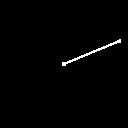

In [ ]:
f = env.get_frame()
f = (f*255).astype(np.uint8)
PIL.Image.fromarray(f)

In [ ]:
f = torch.tensor(f, dtype = torch.float).unsqueeze(0).unsqueeze(0)
mu, logvar = vae.encoder(f)
mu.squeeze(0).detach().cpu().numpy()

array([ 1.57539397e-02, -1.94022954e-02,  1.78047195e-02,  1.85697228e-02,
        2.79960968e-03, -1.99069828e-03,  8.46207142e-04, -5.81806153e-03,
        4.62025404e-03, -1.43215060e-04, -3.34060639e-02, -1.69638768e-02,
        2.07846239e-02, -1.49519239e-02,  1.05196238e-03,  2.72260234e-02,
        1.72745511e-02, -1.18090678e-02, -2.37623155e-02, -1.39406584e-02,
        1.38012022e-02,  1.81556866e-03,  9.37271863e-03,  8.42060894e-03,
        2.61819303e-01,  2.55798697e-02, -2.59553082e-03, -2.35684291e-02,
       -2.23061964e-02, -2.09072642e-02,  1.54056400e-03, -1.71978474e-02,
       -7.44171441e-03, -7.85362720e-03,  3.78417075e-01, -1.65642006e-04,
        6.09418571e-01,  2.72511095e-02,  4.92267311e-03, -2.07422115e-03,
       -3.60959233e-03, -9.53402370e-03, -2.99709104e-03,  2.05355044e-02,
        4.19516265e-02,  2.52800733e-02,  1.23255178e-02, -4.03658450e-02,
        3.52755487e-02,  1.28899626e-02,  1.60006881e-01,  3.27725038e-02,
        8.13898444e-03,  

In [ ]:
g = vae.decoder(mu)

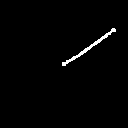

In [ ]:
g = g.squeeze(0).squeeze(0).detach().cpu().numpy()
h = np.where(g <= 0.3, 0, 1)*255
h = h.astype(np.uint8)
PIL.Image.fromarray(h)

# Training Utils

In [ ]:
def optimize(model, optimizer, loss, clip_value = 1):
    optimizer.zero_grad()
    loss.backward()
    clip_grad_value_(model.parameters(), clip_value)
    optimizer.step()

In [ ]:
def soft_update(target, source, tau):
	for a, b in zip(target.parameters(), source.parameters()):
		a.data.copy_(a.data * (1.0 - tau) + b.data * tau)

# Util to Plot Reward

In [ ]:
from IPython import display as ipythondisplay

tic = time.time()
def plot(reward):
    global tic
    if time.time() - tic > 2:

      plt.cla()
      plt.grid(True)
      fig = plt.gcf()
      fig.set_size_inches(9,6)
      plt.plot(reward)
      plt.xlabel('episodes')
      plt.ylabel('rewards')

      ipythondisplay.clear_output(wait=True)
      ipythondisplay.display(plt.gcf())
      tic = time.time()

# **Replay Memory**

In [ ]:
s = 64*4
a = 1

In [ ]:
from recordclass import recordclass

Transitions = recordclass('Transitions', ('states', 'actions', 'next_states', 'rewards', 'dones'))

class ReplayMemory():
    def __init__(self, capacity = 1000, state_dim = s, action_dim = a):
      
        self.length = 0
        self.capacity = capacity
        self.states = np.zeros((capacity, state_dim))
        self.actions = np.zeros((capacity, action_dim))
        self.next_states = np.zeros((capacity, state_dim))
        self.rewards = np.zeros((capacity, 1))
        self.dones = np.zeros((capacity, 1))
      
    def add_transition(self, *args):
        index = self.length % self.capacity

        self.states[index] = args[0]
        self.actions[index] = args[1]
        self.next_states[index] = args[2]
        self.rewards[index] = args[3]
        self.dones[index] = args[4]

        self.length += 1

    def sample(self, batch_size):

        maxind = min(self.length, self.capacity)
        inds = np.random.choice(maxind, batch_size)

        batch = Transitions(self.states[inds],
                            self.actions[inds],
                            self.next_states[inds],
                            self.rewards[inds],
                            self.dones[inds])
        
        for i in range(5):
          batch[i] = torch.tensor(batch[i], dtype=torch.float)

        return batch
    
    def clear(self): 
      self.length = 0
        
    def __len__(self):
      return min(self.length, self.capacity)

# **Q-value Network**

In [ ]:
class DQN(nn.Module):

    def __init__(self, state_dim = s, action_dim = a):
        super(DQN, self).__init__()
        self.l11 = nn.Linear(state_dim, 256)
        self.l12 = nn.Linear(action_dim, 32)

        self.l2 = nn.Linear(256 + 32, 290)
        self.l3 = nn.Linear(290, 290)

        self.last = nn.Linear(290, 1)
        self.last.weight.data.uniform_(-0.05,0.05)
        self.last.bias.data.fill_(0.01)

    def forward(self, states, actions):
        x = torch.cat((self.l11(states), self.l12(actions)),1)
        x = F.silu(x)
        x = F.silu(self.l2(x))
        x = F.silu(self.l3(x))
        x = self.last(x)
        return x

# **Double Q-Network Critic**

In [ ]:
class Critic(nn.Module):
  def __init__(self, state_dim = s, action_dim = a):
    super(Critic, self).__init__()
    self.q1 = DQN(state_dim, action_dim)
    self.q2 = DQN(state_dim, action_dim)
  
  def predict(self, states, actions):
    q1 = self.q1(states, actions)
    q2 = self.q2(states, actions)
    return q1, q2
  
  def forward(self, states, actions):
    q1, q2 = self.predict(states, actions)
    return torch.min(q1, q2)
  
  def calc_loss(self, states, actions, expected_critic_values):
    q1, q2 = self.predict(states, actions)
    loss1 = F.smooth_l1_loss(expected_critic_values, q1)
    loss2 = F.smooth_l1_loss(expected_critic_values, q2)
    return loss1 + loss2
  
  def requires_grad(self, boolean = True):
    for param in self.parameters():
        param.requires_grad = boolean

In [ ]:
def requires_grad(model, boolean = True):
  for param in model.parameters():
      param.requires_grad = boolean

# **Policy Network**

In [ ]:
class Policy(nn.Module):

    def __init__(self, state_dim = s, action_dim = a):
        super(Policy, self).__init__()

        self.l1 = nn.Linear(state_dim, 256)
        self.l2 = nn.Linear(256, 256)
        self.l3 = nn.Linear(256, 256)

        self.mean_layer = nn.Linear(256, action_dim)
        self.mean_layer.weight.data.uniform_(-0.5, 0.5)
        self.mean_layer.bias.data.fill_(0.5)

        self.log_std = nn.Linear(256, action_dim)
        self.log_std.weight.data.uniform_(-0.5,0.5)
        self.log_std.bias.data.fill_(0.1)


    def forward(self, states):

        x = F.silu(self.l1(states))
        x = F.silu(self.l2(x))
        x = F.silu(self.l3(x))

        mean = self.mean_layer(x)
        std = torch.exp(self.log_std(x).clamp(-20, 2))

        return Normal(mean, std)

    def sample(self, states):

        dist = self.forward(states)
        samples = dist.rsample()
        actions = torch.tanh(samples)
        log_probs = dist.log_prob(samples) - torch.log(1 - actions**2 + 1e-8)
        
        return actions, log_probs.mean(axis = 1)

    def choose_action(self, state, training = True):
        
        with torch.no_grad(): 
          state = torch.tensor(state, dtype = torch.float).unsqueeze(0)
          dist = self.forward(state)
          sample = dist.sample() if training else dist.mean
          action = torch.tanh(sample).squeeze(0)

        return np.round(action.cpu().numpy(), 5)

# **Initialize**

In [ ]:
gamma = 0.99   # discount factor
alpha = 0.014    # entropy reward coeff

actor = Policy().to(device)
critic = Critic().to(device)

target_critic = Critic().to(device)
target_critic.load_state_dict(critic.state_dict())

<All keys matched successfully>

In [ ]:
actor_optimizer  = optim.Adam(actor.parameters(), 1e-3)
critic_optimizer = optim.Adam(critic.parameters(), 1e-3)

In [ ]:
memory = ReplayMemory(300000)

In [ ]:
def save(name):
  torch.save({
            'actor': actor.state_dict(),
            'critic': target_critic.state_dict(),
            'actor_optimizer': actor_optimizer.state_dict(),
            'critic_optimizer': critic_optimizer.state_dict(),
            }, name)

In [ ]:
def load(name, device):
  state = torch.load(name, map_location = device)

  actor.load_state_dict(state['actor'])
  critic.load_state_dict(state['critic'])
  actor_optimizer.load_state_dict(state['actor_optimizer'])
  critic_optimizer.load_state_dict(state['critic_optimizer'])

  target_critic.load_state_dict(critic.state_dict())

In [ ]:
save('f2')

In [ ]:
load('f2', device)

In [ ]:
alpha = 0.012    # entropy reward coeff

# **Single training step**

In [ ]:
def train_step(batch_size = 64):

    batch = memory.sample(batch_size)

  #---------------------critic training----------------------------------
    with torch.no_grad(): 
      next_actions, log_probs = actor.sample(batch.next_states)
      next_critic_values = target_critic(batch.next_states, next_actions)
      expected_critic_values = batch.rewards + (1 - batch.dones)*gamma*(next_critic_values - alpha*log_probs)

    critic_loss = critic.calc_loss(batch.states, batch.actions, expected_critic_values)

    optimize(critic, critic_optimizer, critic_loss)
  #---------------------------------------------------------------------


  #---------------------actor training----------------------------------
    critic.requires_grad(False)

    actions, log_probs = actor.sample(batch.states)
    critic_value = critic(batch.states, actions)
    actor_loss = -torch.mean(critic_value - alpha*log_probs)

    optimize(actor, actor_optimizer, actor_loss)

    critic.requires_grad(True)
  #-----------------------------------------------------------------------

  #----------------soft update target critic--------------------------------
    soft_update(target_critic, critic, 0.005)
  #-------------------------------------------------------------------------

In [ ]:
reward_list = []
avg_rewards = []

# **Training**

In [ ]:
env = FJMEnv()

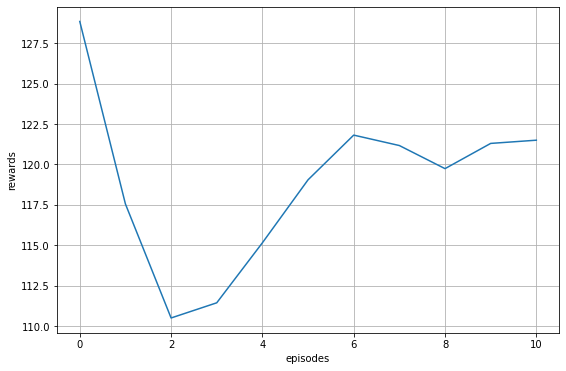

100%|██████████| 10/10 [00:36<00:00,  3.62s/it]


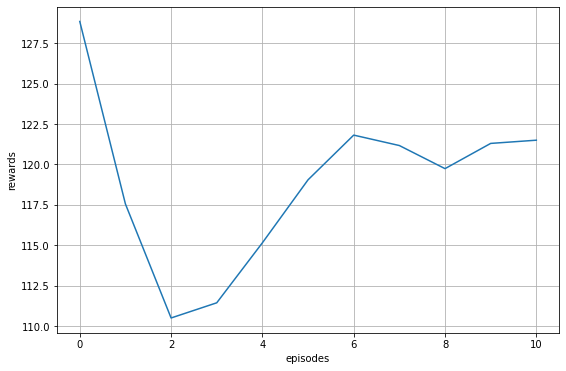

In [ ]:
for i_episode in tqdm(range(5000)):

  state = env.reset()
  total_reward = 0
  done = 0
  steps = 0

  while not done:

    action = actor.choose_action(state)
    next_state, reward, done, info = env.step(action)
    memory.add_transition(state, action, next_state, reward, done)

    total_reward += reward
    state = next_state
    steps += 1

    train_step()
  
  # if len(memory) > 1000:
  #   for _ in range(100):
  #     train_step()

  reward_list.append(total_reward)                
  avg_rewards.append(np.mean(reward_list[-50:])) 

  plot(avg_rewards)

In [ ]:
env = FJMEnv()

a  = 1
def action_fun(state):
    global a
    a = actor.choose_action(state, False)
    return a

states, actions, rewards = env.record(action_fun, 4, init = [np.pi,0,0,0])
display_video()

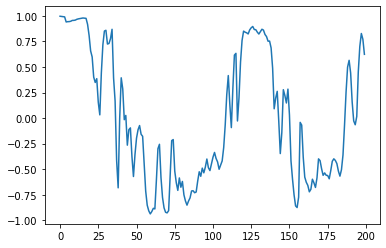

In [ ]:
plt.plot(actions)

In [ ]:
files.download('a.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>